In [1]:
import sys

import pandas as pd

sys.path.append('scripts/')
import flag_dimensionality_reduction as fdr
from utils import *

sys.path.append('Hands/')
from hand_utils import *

import numpy as np
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt


from geomstats.geometry.pre_shape import PreShapeSpace


class GeomstatsShapeSpace():
    """A simple adapter class which uses pymanopt language for geomstats shape space
    """

    def __init__(self, n, k):
        self._man = PreShapeSpace(m_ambient = n, k_landmarks = k)
        self._man.equip_with_group_action("rotations")
        self._man.equip_with_quotient_structure()

    def dist(self, point_a, point_b):
        return self._man.metric.dist(point_a, point_b)

    def exp(self, base_point, tangent_vector):
        return self._man.metric.exp(tangent_vector, base_point=base_point)

    def log(self, base_point, ambient_point):
        return self._man.to_tangent(ambient_point, base_point=base_point)
    
    def random_point(self):
        return self._man.random_point()


INFO: Using numpy backend


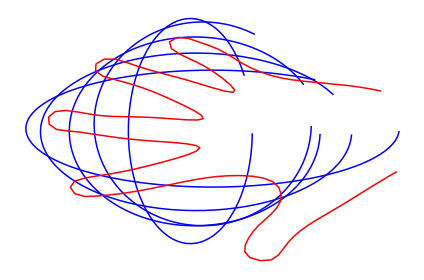

In [2]:
filepath = './Hands/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T


shapes = []
for h in hands:
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    shapes.append(k_shape)


def generate_ellipse_outlier1(seed: int):
    # np.random.seed(seed)

    # # Generate data points on the ellipse
    # x = np.random.normal(0,10, 56)
    # y = np.random.normal(0,10, 56) 

    
    # pt = np.vstack([x,y]).T

    # pt = pt - np.mean(pt, axis = 0)
    # pt = pt/np.linalg.norm(pt)
    # return pt
    np.random.seed(seed)
    # Define ellipse parameters
    center_x = .1*np.random.normal(0,1)  # X-coordinate of the center #was .1
    center_y = .1*np.random.normal(0,1)  # Y-coordinate of the center #was .1
    major_axis = .4+ np.random.normal(0,.1)#np.random.normal(0,.3) # np.random.normal(0,1)  # Length of the major axis
    minor_axis = .4+ np.random.normal(0,.1)#np.random.normal(0,.3)  #np.random.normal(0,1)   # Length of the minor axis


    # Generate data points on the ellipse
    # theta = np.linspace(-0.2, 1.8*np.pi, 56)  # Create 100 equally spaced points around the ellipse
    theta = np.linspace(.1 + np.random.rand(),2*np.pi, 56)
    x = center_x + major_axis * np.cos(theta)
    y = center_y + minor_axis * np.sin(theta)
    
    pt = np.vstack([x,y]).T

    pt = pt - np.mean(pt, axis = 0)
    pt = pt/np.linalg.norm(pt)
    return pt

for i in range(5):
    outlier = generate_ellipse_outlier1(i)
    interp_points = interp(outlier)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'b')
interp_points = interp(shapes[0])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")

plt.tight_layout()

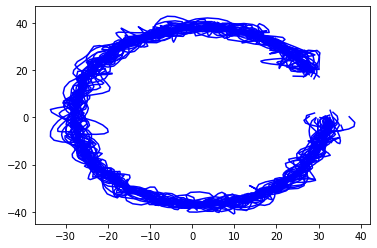

In [3]:
dr_seed = 12345

manifold = GeomstatsShapeSpace(2,56)

x = generate_ellipse_outlier1(0)
# for i in np.linspace(0,1,n_outs):
for i in range(40):
    y = manifold.random_point()
    v = manifold.log(x,y)
    outlier = manifold.exp(x, .1*np.random.rand()*v)
    interp_points = interp(outlier)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'b')

(-44.121117741522994,
 78.81853300544805,
 -55.34999939465929,
 42.780634156964624)

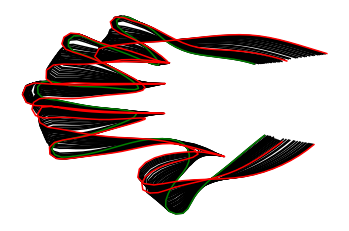

In [4]:
filepath = './Hands/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T
hands1 = []
for h in hands:
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    hands1.append(k_shape)


x = hands1[0]
ys = [hands1[5],hands1[8]]
shapes = []
for i in np.linspace(0,1,40):
    idx = np.random.choice([0,1])
    v = manifold.log(x,ys[idx])
    inlier = manifold.exp(x, i*v)
    z = inlier
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'k')



interp_points = interp(x)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'g')

interp_points = interp(ys[0])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")
interp_points = interp(ys[1])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")

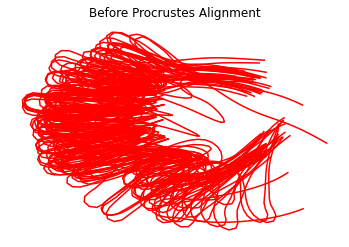

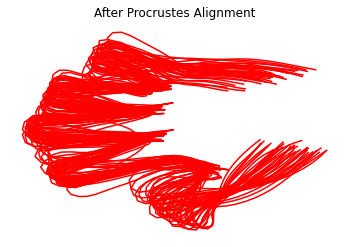

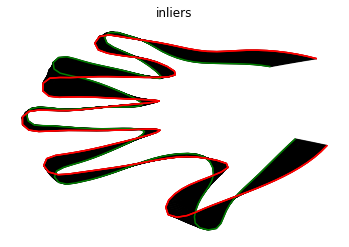

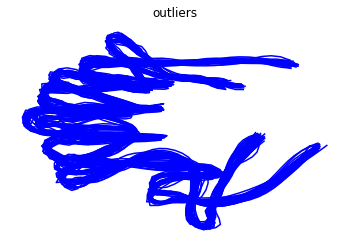

In [153]:


results = pd.DataFrame(columns = ['Num. Outliers','Algorithm', 'AUC'])
fl_type = [1,2]

#33 min to run

trial = 0

n_outs = 100

# load data
filepath = './Hands/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands0 = np.array(segmentationlist).T
hands = procrustes_hand(hands0)

hands1 = []
for h in hands:
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    hands1.append(k_shape)


x = hands1[0]
# ys = [hands1[7],hands1[9]]
# ys = [hands1[9],hands1[10]]
ys = [hands1[7],hands1[7]] #works with 7

shapes = []
for i in np.linspace(0,1,40):
    idx = np.random.choice([0,1])
    v = manifold.log(x,ys[idx])
    inlier = manifold.exp(x, i*v)
    shapes.append(inlier)

plt.figure()
plt.title('inliers')
for z in shapes:
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'k')


interp_points = interp(x)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'g')
interp_points = interp(ys[0])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
interp_points = interp(ys[1])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")

np.random.seed(123)
# x = generate_ellipse_outlier1(0)

for i in range(n_outs):
    x= unmake_1d(hands[np.random.choice([20,24,25,30,39])])
    y = manifold.random_point()
    v = manifold.log(x,y)
    outlier = manifold.exp(x, .05*np.random.rand()*v)
    shapes.append(outlier)

labels = [0]*40 + [1]*n_outs



    

plt.figure()
plt.title('outliers')
for z in shapes[-n_outs:]:
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'b')
    plt.axis("off")


--------------------
iteration 0
objective 0.025717191480810208
flag distance between B0 and B1 1.1342332051891346

--------------------
iteration 1
objective 0.025717191480810208
flag distance between B0 and B1 0.0



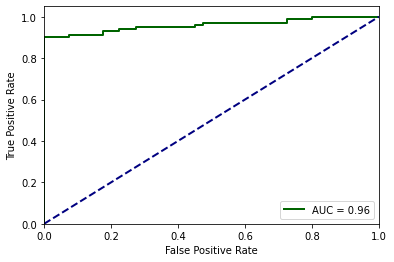

In [158]:
for n_shapes in [200]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_d2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes[:n_shapes], 
                                                  fl_type = [fl_type[-1]], 
                                                  pca_type = 'dpcp', 
                                                  return_ts = True,
                                                  median = median, init = 'rand', 
                                                  rand_seed = dr_seed, verbose = True )

    auc_val, dpcp2_preds, dpcp2_thresh  = run_roc( shapes[:n_shapes], W_d2ours, labels[:n_shapes], 'dpcp', 
                                                  manifold, ts, median,do_plots = True )

In [160]:
dpcp2_thresh

0.032136578476461924

In [159]:
dpcp2_preds

array([0.00283268, 0.00354259, 0.00426124, 0.0049848 , 0.00571134,
       0.00643979, 0.0071695 , 0.00790006, 0.00863119, 0.00936269,
       0.0100944 , 0.01082622, 0.01155805, 0.01228983, 0.0130215 ,
       0.013753  , 0.01448428, 0.01521532, 0.01594606, 0.01667649,
       0.01740656, 0.01813625, 0.01886553, 0.01959438, 0.02032277,
       0.02105068, 0.02177808, 0.02250495, 0.02323127, 0.02395702,
       0.02468216, 0.0254067 , 0.02613059, 0.02685383, 0.02757639,
       0.02829825, 0.02901939, 0.02973979, 0.03045944, 0.0311783 ,
       0.0927901 , 0.09699898, 0.27734331, 0.09240188, 0.01816197,
       0.01052974, 0.51528049, 0.27150624, 0.39326215, 0.17186377,
       0.81786763, 0.2024301 , 0.15992211, 0.08515656, 0.77018679,
       0.16847552, 0.05757565, 0.12517722, 0.3552139 , 0.13850808,
       0.12311222, 0.06793151, 0.04137496, 0.37783515, 0.02379587,
       0.02517201, 0.03502334, 0.24109735, 0.14320353, 0.21876713,
       0.43363961, 0.231535  , 0.48183195, 0.03669104, 0.11542

--------------------
iteration 0
objective 7.220045691199964
flag distance between B0 and B1 1.3996455050204084

--------------------
iteration 1
objective 6.531111428121701
flag distance between B0 and B1 0.23722410273818112

--------------------
iteration 2
objective 6.138400786265123
flag distance between B0 and B1 0.17319727698961024

--------------------
iteration 3
objective 5.962671569909998
flag distance between B0 and B1 0.10428683989062167

--------------------
iteration 4
objective 5.9329925789719695
flag distance between B0 and B1 0.035450879515080684

--------------------
iteration 5
objective 5.929707974805549
flag distance between B0 and B1 0.010166104630650931

--------------------
iteration 6
objective 5.929336497020332
flag distance between B0 and B1 0.0031960624228468937

--------------------
iteration 7
objective 5.929293460473469
flag distance between B0 and B1 0.0010505729113077472

--------------------
iteration 8
objective 5.929293460473469
flag distance between

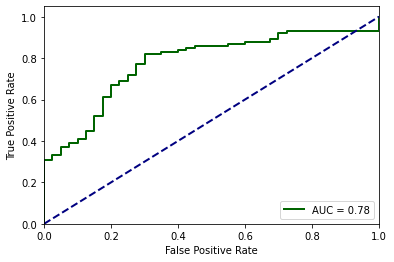

In [156]:
for n_shapes in [200]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_w2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes[:n_shapes], fl_type = [fl_type[-1]], pca_type = 'wpca', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = True )

    auc_val, wpca2_preds, wpca2_thresh  = run_roc( shapes[:n_shapes], W_w2ours, labels[:n_shapes], 'wpca', manifold, ts,     median,do_plots = True )


--------------------
iteration 0
objective 20.554673544790006
flag distance between B0 and B1 1.402968352337458

--------------------
iteration 1
objective 20.668808422928016
flag distance between B0 and B1 0.21789572923569106

--------------------
iteration 2
objective 20.680240600481202
flag distance between B0 and B1 0.06778166888758874

--------------------
iteration 3
objective 20.681521650363123
flag distance between B0 and B1 0.022669447814265147

--------------------
iteration 4
objective 20.681666389003027
flag distance between B0 and B1 0.0076198265357968935

--------------------
iteration 5
objective 20.681682797698624
flag distance between B0 and B1 0.002565504683517068

--------------------
iteration 6
objective 20.6816846611621
flag distance between B0 and B1 0.0008647189019205299

--------------------
iteration 7
objective 20.6816846611621
flag distance between B0 and B1 0.0



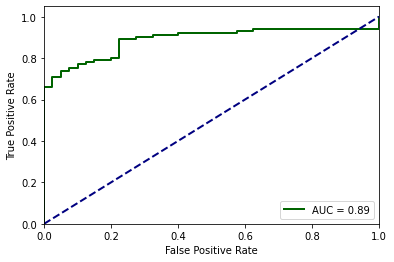

In [155]:
for n_shapes in [200]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_w2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes[:n_shapes], fl_type = [fl_type[-1]], pca_type = 'rpca', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = True )

    auc_val, wpca2_preds, wpca2_thresh  = run_roc( shapes[:n_shapes], W_w2ours, labels[:n_shapes], 'rpca', manifold, ts,     median,do_plots = True )


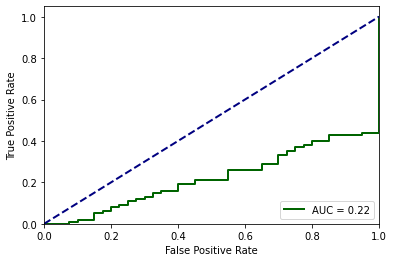

In [154]:
for n_shapes in [200]:
    W_pca, _, ts_pca, mean =   PGA0( manifold, shapes[:n_shapes], [fl_type[-1]], return_ts = True, eps = 1e-9 )

    auc_val, pca_preds, pca_thresh  = run_roc( shapes[:n_shapes], W_pca, labels[:n_shapes], 'pca', manifold, ts_pca, mean, do_plots = True )

In [110]:
pca_preds

array([0.05747417, 0.05555519, 0.05298766, 0.05082073, 0.04871382,
       0.04805883, 0.04471385, 0.04445109, 0.04106804, 0.04097088,
       0.03928941, 0.03649386, 0.03607137, 0.03422743, 0.03338036,
       0.03274492, 0.03042735, 0.02923823, 0.03221299, 0.03250632,
       0.02640093, 0.03376953, 0.0347148 , 0.03584833, 0.02479938,
       0.02484944, 0.02508364, 0.04192289, 0.04374645, 0.0456642 ,
       0.02771739, 0.04973812, 0.05187555, 0.05406943, 0.05631314,
       0.03392219, 0.03542876, 0.0632896 , 0.03863074, 0.04031184,
       0.7837088 , 0.38650973, 0.22700175, 0.25502761, 0.70243616,
       0.85234691, 0.98893058, 0.44438486, 0.24118741, 0.95397573,
       0.57387395, 0.79341704, 0.80634943, 0.4879693 , 0.52438156,
       0.73264097, 0.18795888, 0.11515512, 0.58980657, 0.7456282 ,
       0.09495736, 0.6469411 , 0.42746255, 0.62353636, 0.61017862,
       0.39492463, 0.36331992, 0.88432168, 0.82625779, 0.05814349,
       0.29864674, 0.11350126, 0.30476645, 0.8283483 , 0.73791

(-41.29288392273503, 39.97366581694129, -41.67748831910235, 41.677488319102345)

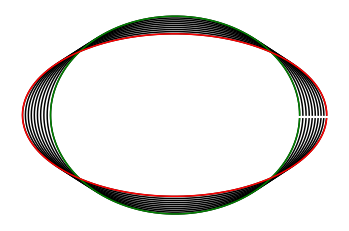

In [27]:

# x = shapes[0]
# y = shapes[7]

x = generate_ellipse_outlier1(0)
y = generate_ellipse_outlier1(1)
v = manifold.log(x,y)


for i in np.linspace(0,1,10):
    z = manifold.exp(x, i*v)
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'k')
    plt.axis("off")



interp_points = interp(x)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'g')
plt.axis("off")

interp_points = interp(y)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")

IndexError: index 56 is out of bounds for axis 0 with size 56

In [31]:
unmake_1d(hands1[0])

IndexError: index 56 is out of bounds for axis 0 with size 56

In [30]:
hands1[0]

array([[ 0.1966087 , -0.06052848],
       [ 0.16709659, -0.09003644],
       [ 0.14092024, -0.11676392],
       [ 0.10193542, -0.15908035],
       [ 0.09135217, -0.17912388],
       [ 0.07742902, -0.198608  ],
       [ 0.06684577, -0.19805273],
       [ 0.0573772 , -0.19137294],
       [ 0.05849188, -0.16353078],
       [ 0.06907513, -0.1418173 ],
       [ 0.08856754, -0.10451486],
       [ 0.08243887, -0.07723212],
       [ 0.04790863, -0.06609774],
       [-0.01892663, -0.0816867 ],
       [-0.06793944, -0.0956057 ],
       [-0.08186259, -0.09783506],
       [-0.09857036, -0.09783506],
       [-0.1069284 , -0.09059585],
       [-0.1069284 , -0.0783468 ],
       [-0.09133116, -0.06888237],
       [-0.07629333, -0.06498306],
       [-0.02783994, -0.04772416],
       [ 0.01281898, -0.02266663],
       [-0.03396446, -0.01209167],
       [-0.08910179, -0.00095315],
       [-0.10748367,  0.00294202],
       [-0.12307677,  0.00684133],
       [-0.12920544,  0.02243029],
       [-0.1225215 ,

In [27]:
hands

array([[1.0035 , 0.93228, 0.86911, ..., 0.79912, 0.783  , 0.75612],
       [1.0102 , 0.92019, 0.8503 , ..., 0.79778, 0.783  , 0.75478],
       [1.0102 , 0.9175 , 0.83282, ..., 0.80046, 0.78703, 0.75344],
       ...,
       [1.064  , 1.0049 , 0.96589, ..., 0.72522, 0.74941, 0.76419],
       [1.0492 , 1.0197 , 1.0102 , ..., 0.74537, 0.75747, 0.77493],
       [1.0519 , 1.0344 , 1.0197 , ..., 0.73597, 0.75209, 0.77628]])

In [25]:
x-y

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [6]:
np.linalg.norm(W_d2ours.T @ ts)

0.0004783143183623673

(-37.08842273324505, 58.93615304103212, -53.32156730983137, 44.62418627791848)

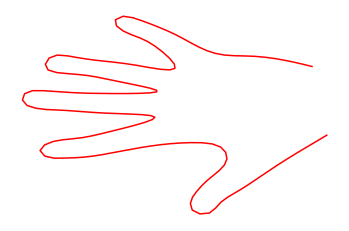